### Matterport 패키지를 이용하여 Balloon 데이터 세트를 학습하고 이를 기반으로 Segmentation 적용
* Matterport 패키지의 학습 프로세스를 상세히 설명.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import cv2

%matplotlib inline

In [2]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

/home/younggi.kim999/anaconda3/envs/tf113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/younggi.kim999/anaconda3/envs/tf113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/younggi.kim999/anaconda3/envs/tf113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/younggi.kim999/anac

#### 주요 수행 모듈인 balloon 모듈을 setup 하여 import하지 않고, 소스코드에서 바로 import 수행.
##### 이를 위해 PATH에 balloon.py 파일이 있는 디렉토리를 지정하고 import 를 적용

In [3]:
#Mask_RCNN 패키지의 samples/balloon 디렉토리의 balloon.py 를 import 한다. 
ROOT_DIR = os.path.abspath(".")
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN/samples/balloon/"))

import balloon

#### balloon 모듈은 어떠한 API들로 구성되어 있는지 직접 소스코드에서 확인. 

In [ ]:
!cat "./Mask_RCNN/samples/balloon/balloon.py"

#### balloon 데이터 세트가 제대로 되어 있는지 확인.  train과 val 서브 디렉토리가 ./Mask_RCNN/dataset/balloon 에 존재해야 함. 

In [4]:
import subprocess
from pathlib import Path

HOME_DIR = str(Path.home())
BALLOON_DATA_DIR = os.path.join(HOME_DIR, "DLCV/data/balloon")

#### balloon 모듈에 설정된 Config 셋업. GPU 갯수, Batch시 image갯수가 사전 설정 되어 있음. 

In [ ]:
config = balloon.BalloonConfig()
config.display()

#### balloon 모듈에서 balloon 데이터 세트 로딩. 

In [ ]:
# Dataset 로딩한다. . 

dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DATA_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

#### balloon 모듈에서 로딩한 balloon 데이터 세트의 세부 정보 확인. 

In [ ]:
# dataset의 image_info는 리스트 객체이며 내부 원소로 이미지별 세부 정보를 딕셔너리로 가지고 있음. 
# dataset의 image_ids 는 이미지의 고유 id나 이름이 아니라 dataset에서 이미지의 상세 정보를 관리하기 위한 리스트 인덱스에 불과 

print('#### balloon 데이터 세트 이미지의 인덱스 ID들 ####')
print(dataset.image_ids)
print('\n ##### balloon 데이터 세트의 이미지 정보들 ####')
print(dataset.image_info)

#### polygon 정보 확인

In [ ]:
image_28 = dataset.image_info[28]
polygons = image_28['polygons']
polygon_x = polygons[0]['all_points_x']
polygon_y = polygons[0]['all_points_y']
print(len(polygon_x))
print('polygon_x:', polygon_x, 'polygon_y:',polygon_y)

polygon_xy = [(x, y) for (x, y) in zip(polygon_x, polygon_y)]
print('polygon_xy:', polygon_xy)

In [ ]:
image_28_array = cv2.imread(os.path.join(BALLOON_DATA_DIR,'train/'+image_28['id']))
for position in polygon_xy:
    cv2.circle(image_28_array, position, 3, (255, 0, 0), -1)

plt.figure(figsize=(8, 8))
plt.axis('off')    
plt.imshow(image_28_array)

In [ ]:
np.random.seed(99)
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
print('image_ids:', image_ids)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    # 지정된 image_id에 있는 mask 를 로딩하고 시각화를 위한 mask정보들과 대상 클래스 ID들을 추출
    mask, class_ids = dataset.load_mask(image_id)
    #원본 데이터와 여러개의 클래스들에 대해 Mask를 시각화 하되, 가장 top 클래스에 대해서는 클래스명까지 추출. 나머지는 배경
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
image = dataset.load_image(28)
print(image.shape)
print(image_28['polygons'])

#### polygon 형태의 데이터를 boolean mask 형태로 변환

In [ ]:
import skimage

img = np.zeros((10, 10), dtype=np.uint8)
r = np.array([1, 2, 8])
c = np.array([1, 7, 4])
print('img:', img)
# r과 c로 지정된 인덱스에 있는 img 값만 1로 설정함. 
rr, cc = skimage.draw.polygon(r, c)
img[rr, cc] = 1
print('row positions:',rr, 'column positions:',cc)
print('0, 1로 masking된 img:\n',img)
print('Boolean형태로 masking된 img:\n',img.astype(np.bool))

In [ ]:
mask, class_ids = dataset.load_mask(28)
print("mask shape:", mask.shape, "class_ids:", class_ids)
print(mask)

In [ ]:
image = dataset.load_image(28)
mask, class_ids = dataset.load_mask(28)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

#### ballon 데이터 세트의 image정보, 클래스 정보, mask 정보의 추출과 변환을 위한 BallonDataset 생성

In [5]:
class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # 클래스 id와 클래스명 등록은 Dataset의 add_class()를 이용. 
        self.add_class("balloon", 1, "balloon")

        # train또는 val 용도의 Dataset 생성만 가능. 
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        # json 형태의 annotation을 로드하고 파싱. 
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys
        
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    '''def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    '''

In [6]:
annotations = json.load(open(os.path.join(BALLOON_DATA_DIR, "train/via_region_data.json")))
annotations

SyntaxError: invalid syntax (<ipython-input-6-43856379df07>, line 1)

In [7]:
annotations = list(annotations.values())
annotations

[{'fileref': '',
  'size': 1115004,
  'filename': '34020010494_e5cb88e1c4_k.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {'0': {'shape_attributes': {'name': 'polygon',
     'all_points_x': [1020,
      1000,
      994,
      1003,
      1023,
      1050,
      1089,
      1134,
      1190,
      1265,
      1321,
      1361,
      1403,
      1428,
      1442,
      1445,
      1441,
      1427,
      1400,
      1361,
      1316,
      1269,
      1228,
      1198,
      1207,
      1210,
      1190,
      1177,
      1172,
      1174,
      1170,
      1153,
      1127,
      1104,
      1061,
      1032,
      1020],
     'all_points_y': [963,
      899,
      841,
      787,
      738,
      700,
      663,
      638,
      621,
      619,
      643,
      672,
      720,
      765,
      800,
      860,
      896,
      942,
      990,
      1035,
      1079,
      1112,
      1129,
      1134,
      1144,
      1153,
      1166,
      1166,
      1150,
   

### balloon 데이터 세트의 학습 수행. 

#### 학습과 Validation용 Dataset 설정.

In [7]:
import skimage

# Training dataset.
dataset_train = BalloonDataset()
dataset_train.load_balloon(BALLOON_DATA_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BalloonDataset()
dataset_val.load_balloon(BALLOON_DATA_DIR, "val")
dataset_val.prepare()

#### Config 설정

In [8]:
from mrcnn.config import Config

TRAIN_IMAGE_CNT = len(dataset_train.image_info)
VALID_IMAGE_CNT = len(dataset_val.image_info)

class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    
    # 추가.
    GPU_COUNT = 1

    # 원본에서 수정.
    #STEPS_PER_EPOCH = TRAIN_IMAGE_CNT  // IMAGES_PER_GPU
    #VALIDATION_STEPS = VALID_IMAGE_CNT  // IMAGES_PER_GPU
    
    # 원본 STEPS_PER_EPOCH
    STEPS_PER_EPOCH = TRAIN_IMAGE_CNT  // IMAGES_PER_GPU
    VALIDATION_STEPS = VALID_IMAGE_CNT  // IMAGES_PER_GPU

    #BACKBONE = 'resnet101'
    
# config 설정. 
train_config = BalloonConfig()
train_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

#### 기반 Mask RCNN Training 모델 생성 및 초기 weight값 로딩

In [9]:
import mrcnn.model as modellib
from mrcnn.model import log

balloon_model = modellib.MaskRCNN(mode="training", config=train_config, model_dir='./snapshots')

# COCO 데이터 세트로 pretrained 된 모델을 이용하여 초기 weight값 로딩. 
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "./pretrained/mask_rcnn_coco.h5")
balloon_model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
Colocations handled automatically by placer.


#### 학습 수행

In [10]:
'''
데이터 세트가 작고,단 하나의 클래스임. 
pretrained 된 Coco 데이터 세트로 초기 weight 설정되었기에 RPN과 classifier만 학습해도 모델 성능은 큰 영향이 없을 거라 예상
all: All the layers
3+: Train Resnet stage 3 and up
4+: Train Resnet stage 4 and up
5+: Train Resnet stage 5 and up
'''
print("Training network heads")
balloon_model.train(dataset_train, dataset_val,
            learning_rate=train_config.LEARNING_RATE,
            epochs=30,
            layers='heads')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: ./snapshots/balloon20200304T0506/mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


/home/younggi.kim999/anaconda3/envs/tf113/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/younggi.kim999/anaconda3/envs/tf113/lib/python3.6/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
61/61 [==============================] - 72s 1s/step - loss: 1.0787 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.5373 - mrcnn_mask_loss: 0.1837 - val_loss: 0.7319 - val_rpn_class_loss: 0.0369 - val_rpn_bbox_loss: 0.1965 - val_mrcnn_class_loss: 0.0543 - val_mrcnn_bbox_loss: 0.3360 - val_mrcnn_mask_loss: 0.1083
Epoch 2/30
61/61 [==============================] - 29s 482ms/step - loss: 0.6357 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.1356 - val_loss: 0.6004 - val_rpn_class_loss: 0.0298 - val_rpn_bbox_loss: 0.1480 - val_mrcnn_class_loss: 0.0797 - val_mrcnn_bbox_loss: 0.2168 - val_mrcnn_mask_loss: 0.1261
Epoch 3/30
61/61 [==============================] - 28s 466ms/step - loss: 0.5566 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.1304 - val_loss: 0.8434 - val_rpn_class_loss

Epoch 23/30
61/61 [==============================] - 27s 449ms/step - loss: 0.1309 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0631 - val_loss: 0.6424 - val_rpn_class_loss: 0.0612 - val_rpn_bbox_loss: 0.3318 - val_mrcnn_class_loss: 0.0370 - val_mrcnn_bbox_loss: 0.0775 - val_mrcnn_mask_loss: 0.1348
Epoch 24/30
61/61 [==============================] - 28s 456ms/step - loss: 0.1669 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0773 - val_loss: 0.4357 - val_rpn_class_loss: 0.0219 - val_rpn_bbox_loss: 0.1458 - val_mrcnn_class_loss: 0.0774 - val_mrcnn_bbox_loss: 0.0901 - val_mrcnn_mask_loss: 0.1005
Epoch 25/30
61/61 [==============================] - 27s 447ms/step - loss: 0.1488 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0684 - val_loss: 0.7352 - val_rpn_clas

### 학습이 완료된 모델을 이용하여 inference 수행. 
#### config를 inference용으로 변경

In [20]:
class InferenceConfig(BalloonConfig):
    # NAME은 학습모델과 동일한 명을 부여
    NAME='balloon'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
        
infer_config = InferenceConfig()
infer_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

#### 학습된 모델의 weight 파일을 MaskRCNN의 inference 모델로 로딩. 

In [21]:
model = modellib.MaskRCNN(mode="inference", model_dir='./snapshots', config=infer_config)
# callback에 의해 model weights 가 파일로 생성되며, 가장 마지막에 생성된 weights 가 가장 적은 loss를 가지는 것으로 가정. 
weights_path = model.find_last()
print('model path:', weights_path)
# 지정된 weight 파일명으로 모델에 로딩. 
model.load_weights(weights_path, by_name=True)

model path: ./snapshots/balloon20200304T0506/mask_rcnn_balloon_0030.h5
Re-starting from epoch 30


#### Instance Segmentation을 수행할 파일들을 dataset로 로딩. val 디렉토리에 있는 파일들을 로딩. 

In [22]:
# Inference를 위해 val Dataset 재로딩. 
dataset_val = BalloonDataset()
dataset_val.load_balloon(BALLOON_DATA_DIR, "val")
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 13
Classes: ['BG', 'balloon']


In [23]:
from mrcnn import model as modellib

# dataset중에 임의의 파일을 한개 선택. 
#image_id = np.random.choice(dataset.image_ids)
image_id = 5
image, image_meta, gt_class_id, gt_bbox, gt_mask=modellib.load_image_gt(dataset_val, infer_config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image ID: balloon.5603212091_2dfe16ea72_b.jpg (5) 
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


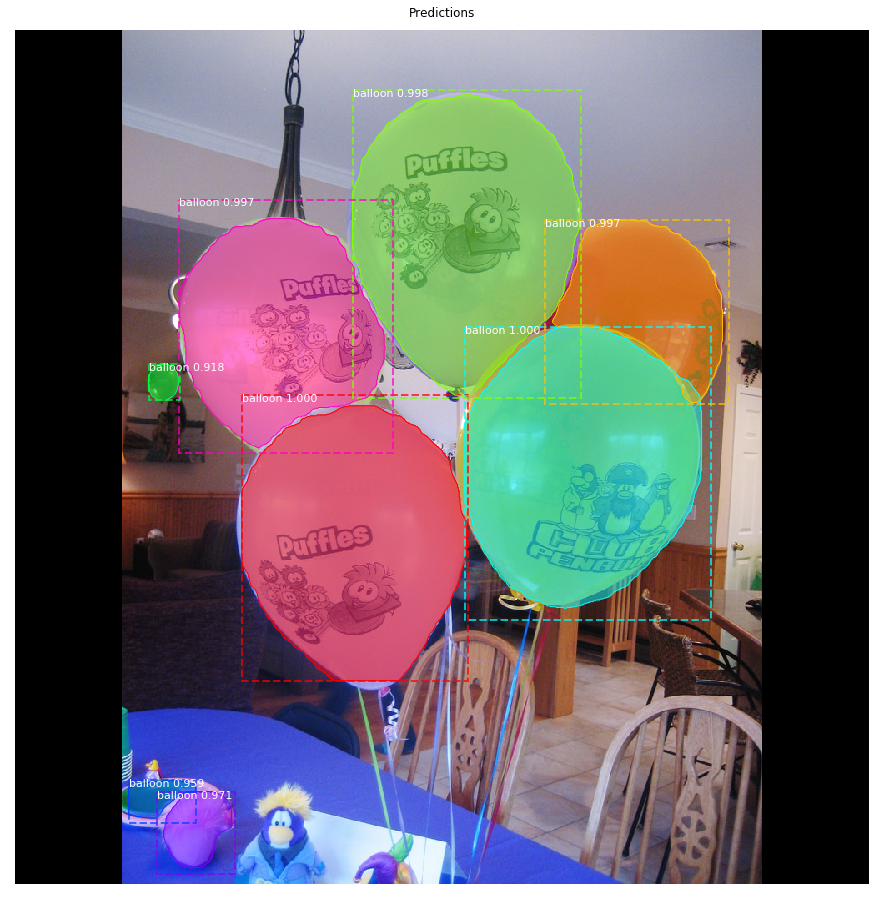

In [24]:
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], 
                            title="Predictions")

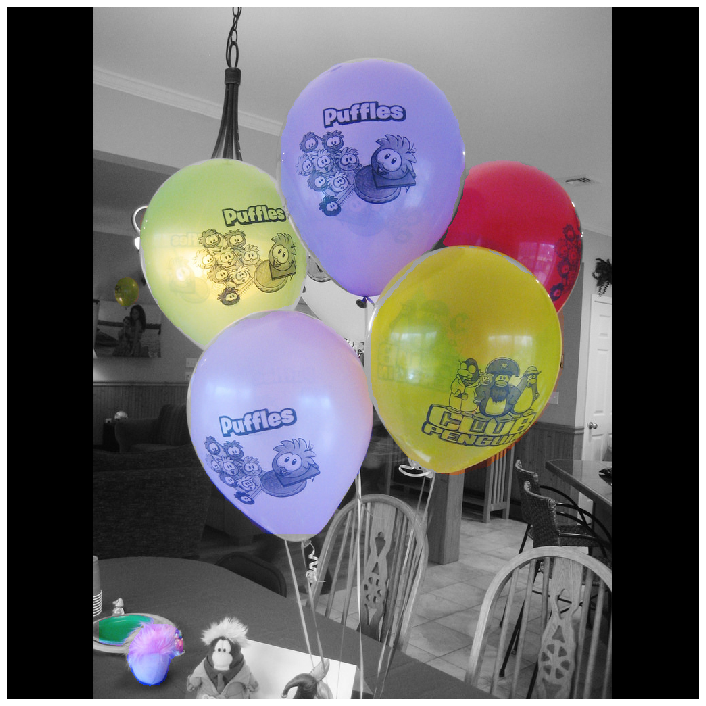

In [25]:
#Mask_RCNN 패키지의 samples/balloon 디렉토리의 balloon.py 를 import 한다. 
ROOT_DIR = os.path.abspath(".")
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN/samples/balloon/"))

import balloon
from mrcnn.visualize import display_images

splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

In [29]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

#### 각 변수 shape debug

In [26]:
print('image shape:',image.shape, 'r mask shape:',r['masks'].shape)
mask = (np.sum(r['masks'], -1, keepdims=True) >= 1)
print('sum mask shape:',mask.shape)

image shape: (1024, 1024, 3) r mask shape: (1024, 1024, 8)
sum mask shape: (1024, 1024, 1)


#### np.sum() 테스트

In [27]:
a = np.ones((10, 10, 3))
#print(a)
#print(np.sum(a))
print(np.sum(a, axis=-1).shape)
print(np.sum(a, -1, keepdims=True).shape)
print(np.sum(a, -1, keepdims=True) >=1 )

(10, 10)
(10, 10, 1)
[[[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
 

#### np.where() 테스트

In [28]:
test_mask = (np.sum(a, -1, keepdims=True) >=1)
print(test_mask.shape)
for i in range(5):
    for j in range(5):
        test_mask[i, j, 0] = False
        
test_image = np.ones((10, 10, 3))
test_gray = np.zeros((10, 10, 3))
np.where(test_mask, test_image, test_gray)

(10, 10, 1)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
  

#### Video에 color splash를 적용. 

In [33]:
from IPython.display import clear_output, Image, display, Video, HTML
Video('../../data/video/balloon_dog02.mp4')

#### Video color splash를 적용한 함수를 생성하고 이를 이용해 video color splash 수행. 

In [30]:
import cv2
import time

def detect_video_color_splash(model, video_input_path=None, video_output_path=None):

    cap = cv2.VideoCapture(video_input_path)
    codec = cv2.VideoWriter_fourcc(*'XVID')
    fps = round(cap.get(cv2.CAP_PROP_FPS))
    vid_writer = cv2.VideoWriter(video_output_path, codec, fps, (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                                                                 round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("총 Frame 개수: {0:}".format(total))

    frame_index = 0
    success = True
    while True:
        
        hasFrame, image_frame = cap.read()
        if not hasFrame:
            print('End of frame')
            break
        frame_index += 1
        print("frame index:{0:}".format(frame_index), end=" ")
        
        # OpenCV returns images as BGR, convert to RGB
        image_frame = image_frame[..., ::-1]
        start=time.time()
        # Detect objects
        r = model.detect([image_frame], verbose=0)[0]
        print('detected time:', time.time()-start)
        # Color splash
        splash = color_splash(image_frame, r['masks'])
        # RGB -> BGR to save image to video
        splash = splash[..., ::-1]
        # Add image to video writer
        vid_writer.write(splash)
    
    vid_writer.release()
    cap.release()       
    
    print("Saved to ", video_output_path)
    
detect_video_color_splash(model, video_input_path='../../data/video/balloon_dog02.mp4', 
                          video_output_path='../../data/output/balloon_dog02_output.avi')


총 Frame 개수: 630
frame index:1 detected time: 0.31290125846862793
frame index:2 detected time: 0.30846691131591797
frame index:3 detected time: 0.3115830421447754
frame index:4 detected time: 0.33725786209106445
frame index:5 detected time: 0.3033273220062256
frame index:6 detected time: 0.3335404396057129
frame index:7 detected time: 0.31287717819213867
frame index:8 detected time: 0.3347344398498535
frame index:9 detected time: 0.3106820583343506
frame index:10 detected time: 0.3334169387817383
frame index:11 detected time: 0.31121397018432617
frame index:12 detected time: 0.3081650733947754
frame index:13 detected time: 0.3013114929199219
frame index:14 detected time: 0.29950809478759766
frame index:15 detected time: 0.3020596504211426
frame index:16 detected time: 0.32896876335144043
frame index:17 detected time: 0.30345582962036133
frame index:18 detected time: 0.33869314193725586
frame index:19 detected time: 0.3048667907714844
frame index:20 detected time: 0.3038976192474365
fram

frame index:166 detected time: 0.33521437644958496
frame index:167 detected time: 0.30800962448120117
frame index:168 detected time: 0.32171058654785156
frame index:169 detected time: 0.31297850608825684
frame index:170 detected time: 0.3169393539428711
frame index:171 detected time: 0.30314183235168457
frame index:172 detected time: 0.3250553607940674
frame index:173 detected time: 0.32856106758117676
frame index:174 detected time: 0.3086817264556885
frame index:175 detected time: 0.3001382350921631
frame index:176 detected time: 0.3099699020385742
frame index:177 detected time: 0.2955784797668457
frame index:178 detected time: 0.31038761138916016
frame index:179 detected time: 0.31396007537841797
frame index:180 detected time: 0.30624961853027344
frame index:181 detected time: 0.3394465446472168
frame index:182 detected time: 0.3327670097351074
frame index:183 detected time: 0.30473971366882324
frame index:184 detected time: 0.3397519588470459
frame index:185 detected time: 0.3354618

frame index:329 detected time: 0.3325479030609131
frame index:330 detected time: 0.3072059154510498
frame index:331 detected time: 0.3364856243133545
frame index:332 detected time: 0.3350832462310791
frame index:333 detected time: 0.30165958404541016
frame index:334 detected time: 0.2999897003173828
frame index:335 detected time: 0.29828310012817383
frame index:336 detected time: 0.2980177402496338
frame index:337 detected time: 0.28684425354003906
frame index:338 detected time: 0.28862929344177246
frame index:339 detected time: 0.303790807723999
frame index:340 detected time: 0.30173444747924805
frame index:341 detected time: 0.3068714141845703
frame index:342 detected time: 0.30045413970947266
frame index:343 detected time: 0.29922938346862793
frame index:344 detected time: 0.3066112995147705
frame index:345 detected time: 0.3043961524963379
frame index:346 detected time: 0.28913331031799316
frame index:347 detected time: 0.33719730377197266
frame index:348 detected time: 0.307401418

frame index:492 detected time: 0.297199010848999
frame index:493 detected time: 0.30446839332580566
frame index:494 detected time: 0.33933544158935547
frame index:495 detected time: 0.3331441879272461
frame index:496 detected time: 0.3116161823272705
frame index:497 detected time: 0.31267619132995605
frame index:498 detected time: 0.30942225456237793
frame index:499 detected time: 0.3092026710510254
frame index:500 detected time: 0.305248498916626
frame index:501 detected time: 0.29558825492858887
frame index:502 detected time: 0.30380797386169434
frame index:503 detected time: 0.29774951934814453
frame index:504 detected time: 0.33103108406066895
frame index:505 detected time: 0.30776476860046387
frame index:506 detected time: 0.2965543270111084
frame index:507 detected time: 0.3010900020599365
frame index:508 detected time: 0.3026752471923828
frame index:509 detected time: 0.29949307441711426
frame index:510 detected time: 0.2964448928833008
frame index:511 detected time: 0.288855552

#### 생성된 Output 파일을 Object Storage에 저장한 뒤 확인

In [34]:
!gsutil cp ../../data/output/balloon_dog02_output.avi gs://my_bucket_dlcv/data/output/balloon_dog02_output.avi

Copying file://../../data/output/balloon_dog02_output.avi [Content-Type=video/x-msvideo]...
/ [1 files][  6.6 MiB/  6.6 MiB]                                                
Operation completed over 1 objects/6.6 MiB.                                      
